## Data augmentation

In [15]:
import os
import cv2
import pandas as pd
from glob import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from time import time

In [7]:
img_height, img_width = 224,224
batch_size = 20

train_dir = "Data/train/"
valid_dir = "Data/test/"

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=30, 
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


Found 164 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


In [9]:
train_generator.class_indices

{'Audrey': 0, 'Hank': 1, 'Mag': 2}

### Transfer Learning

In [10]:
fc1_hidden = 512
fc2_hidden = 256
fc3_hidden = 128
num_class = 2
lr = 0.001
momentum=0.9
epoch = 30

In [11]:
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_vggface.vggface import VGGFace

# VGG16_base = keras.applications.VGG16(weights='imagenet', include_top=False)

# x = VGG16_base.output
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(fc1_hidden,activation='relu')(x)
# x = keras.layers.Dense(fc2_hidden,activation='relu')(x)
# x = keras.layers.Dense(fc3_hidden,activation='relu')(x)

# predictions = Dense(num_class, activation='softmax')(x)

# VGG16_transfer = Model(inputs=VGG16_base.input, outputs=predictions)

# VGG16_transfer.compile(loss = 'categorical_crossentropy',
#                        optimizer = keras.optimizers.SGD(lr=lr, momentum=momentum),
#                        metrics=['accuracy'])

# VGG16_transfer.summary()


#custom parameters
nb_class = 3
hidden_dim = 512

vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('pool5').output

x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)


custom_vgg_model.compile(loss = 'categorical_crossentropy',
                       optimizer = keras.optimizers.SGD(lr=lr, momentum=momentum),
                       metrics=['accuracy'])

custom_vgg_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [13]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history_VGG16 = custom_vgg_model.fit_generator(train_generator,
                                             epochs=epoch,
                                             shuffle=True,
                                             verbose=1,
                                             callbacks=[earlystop],
                                             validation_data=valid_generator)

model_path = 'VGG16_Face.h5'
custom_vgg_model.save(model_path)


Epoch 1/30
9/9 [==============================] - 6s 639ms/step - loss: 0.0256 - acc: 0.9888 - val_loss: 0.0599 - val_acc: 0.9722
Epoch 2/30
9/9 [==============================] - 5s 532ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 3/30
9/9 [==============================] - 5s 541ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 4/30
9/9 [==============================] - 5s 541ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 5/30
9/9 [==============================] - 5s 556ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 6/30
9/9 [==============================] - 5s 543ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 7/30
9/9 [==============================] - 5s 551ms/step - loss: 0.0089 - acc: 0.9944 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 8/30
9/9 [==============================] - 5s 565ms/step - loss: 0.0031 - acc: 1.00

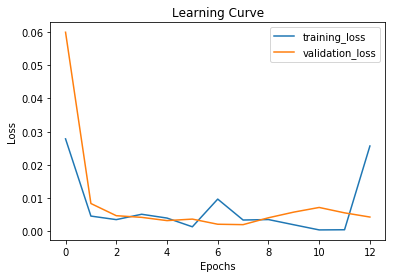

In [16]:
training_loss = history_VGG16.history['loss']
val_loss = history_VGG16.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

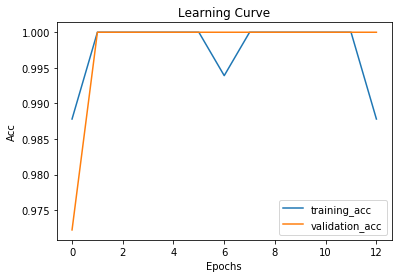

In [17]:
training_acc = history_VGG16.history['acc']
val_acc = history_VGG16.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()